In [109]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import MmCorpus
from gensim.corpora import Dictionary
from collections import Counter, defaultdict
from numpy.random import seed
import re
from metadata.metadata import ACL_metadata
from _topic_modeling.lda_loader import Loader
import _pickle as pkl
from metadata import Gender
from _storage.storage import FileDir
import matplotlib.pyplot as plt
import numpy as np
import logging
from os.path import join
import gensim 
fd = FileDir()
seed(1)
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [2]:
loader = Loader()

loaded corpus index from /home/ramona/Desktop/Honours-LDA/aan/save/acl_bow10.mm.index
initializing corpus reader from /home/ramona/Desktop/Honours-LDA/aan/save/acl_bow10.mm
accepted corpus with 22278 documents, 63996 features, 10941296 non-zero entries
loading LdaModel object from /home/ramona/Desktop/Honours-LDA/aan/save/ldaseed310lda
loading expElogbeta from /home/ramona/Desktop/Honours-LDA/aan/save/ldaseed310lda.expElogbeta.npy with mmap=None
loading eta from /home/ramona/Desktop/Honours-LDA/aan/save/ldaseed310lda.eta.npy with mmap=None
setting ignored attribute id2word to None
setting ignored attribute dispatcher to None
setting ignored attribute state to None
loaded /home/ramona/Desktop/Honours-LDA/aan/save/ldaseed310lda
loading LdaModel object from /home/ramona/Desktop/Honours-LDA/aan/save/ldaseed310lda.state
loaded /home/ramona/Desktop/Honours-LDA/aan/save/ldaseed310lda.state


In [7]:
lda = loader.model
lda.id2word = loader.id2word
corpus = loader.corpus
dictionary = loader.dic
dids = loader.doc_ids
doc_topics = loader.doc_topics
topic_corresp = loader.topic_corresp
acl = ACL_metadata()
df = acl.modeling_df

Remember to use acl.modeling_files and modeling_df for topic modeling


In [4]:
gensimcm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')

In [5]:
gensimcm.get_coherence()

CorpusAccumulator accumulated stats from 1000 documents
CorpusAccumulator accumulated stats from 2000 documents
CorpusAccumulator accumulated stats from 3000 documents
CorpusAccumulator accumulated stats from 4000 documents
CorpusAccumulator accumulated stats from 5000 documents
CorpusAccumulator accumulated stats from 6000 documents
CorpusAccumulator accumulated stats from 7000 documents
CorpusAccumulator accumulated stats from 8000 documents
CorpusAccumulator accumulated stats from 9000 documents
CorpusAccumulator accumulated stats from 10000 documents
CorpusAccumulator accumulated stats from 11000 documents
CorpusAccumulator accumulated stats from 12000 documents
CorpusAccumulator accumulated stats from 13000 documents
CorpusAccumulator accumulated stats from 14000 documents
CorpusAccumulator accumulated stats from 15000 documents
CorpusAccumulator accumulated stats from 16000 documents
CorpusAccumulator accumulated stats from 17000 documents
CorpusAccumulator accumulated stats from

-1.6372640654636186

In [10]:
females_topics = []
females_topics_proportions = defaultdict(int) # P(topic|gender)'
males_topics_proportions = defaultdict(int)
fem_norm = 0 # normalizer
male_norm = 0
males_topics = []
for i, file in enumerate(acl.modeling_files):
    try:
        topics = doc_topics[i]
        gender = df.loc[acl.get_id(file)]["genders"][0] #first author
        if gender == Gender.female:
            for topic, p in topics:
                females_topics_proportions[topic_corresp[topic]] += p
            fem_norm +=1
        elif gender == Gender.male:
            for topic, p in topics:
                males_topics_proportions[topic_corresp[topic]] += p
            male_norm +=1
    except KeyError:
        pass

In [14]:
p_fem = dict()
for idx in range(100):
    f = (females_topics_proportions[topic_corresp[idx]] ) / fem_norm
    m = (males_topics_proportions[topic_corresp[idx]] ) / male_norm
    odds = (f * (1-f)) / (m * (1-m))
    if odds > 1.1:
        p_fem[topic_corresp[idx]] = odds
    if odds > 1.5:
        print("Females are {0:.2f} more likeky than men to write about topic {1:d}".format(odds, idx))
        print("Most common words for this topic are:")
        print(topic_corresp[idx])
        for w,p in lda.show_topic(idx,10):
            print(w,)
        print("-"*30)
        print("-"*30)


Females are 1.64 more likeky than men to write about topic 1
Most common words for this topic are:
Topic 16 #Dialog
strategy
agent
evidence
conflict
proposal
accept
reject
interaction
argumentation
negotiation
------------------------------
------------------------------
Females are 1.60 more likeky than men to write about topic 9
Most common words for this topic are:
Topic 90 #LinguisticAnnotation
arabic
msa
abbreviation
dialect
habash
morphological
dialectal
write
bic
diacritic
------------------------------
------------------------------
Females are 1.92 more likeky than men to write about topic 10
Most common words for this topic are:
Topic 5 #GraphTheory+BioNLP
medical
patient
disease
clinical
drug
health
swedish
uml
symptom
disorder
------------------------------
------------------------------
Females are 1.62 more likeky than men to write about topic 21
Most common words for this topic are:
Topic 33 #SpeechActs+BDI
action
dialog
plan
goal
act
belief
discourse
speaker
intention
u

In [15]:
p_male = dict()
for idx in range(100):
    f = (females_topics_proportions[topic_corresp[idx]]) / fem_norm
    m = (males_topics_proportions[topic_corresp[idx]]) / male_norm
    odds = (m * (1-m)) / (f * (1-f))
    if odds > 1.1:
        p_male[topic_corresp[idx]] = odds
    if odds > 1.5:
        print("Males are {0:.2f} more likeky than females to write about topic {1:d}".format(odds, idx))
        print("Most common words for this topic are:")
        print(topic_corresp[idx])
        for w,p in lda.show_topic(idx,10):
            print(w,)
        print("-"*30)
        print("-"*30)


Males are 1.72 more likeky than females to write about topic 11
Most common words for this topic are:
Topic 70 #ClassicParsing
grammar
parse
parser
item
chart
terminal
parsing
free
derivation
production
------------------------------
------------------------------
Males are 1.51 more likeky than females to write about topic 26
Most common words for this topic are:
Topic 97 #ProbabilityTheory
probability
estimate
parameter
distribution
log
likelihood
probabilistic
estimation
equation
statistical
------------------------------
------------------------------
Males are 1.98 more likeky than females to write about topic 81
Most common words for this topic are:
Topic 17 #FiniteStateModels(Automata)
string
symbol
finite
transducer
transition
automaton
stack
right
regular
sequence
------------------------------
------------------------------
Males are 1.82 more likeky than females to write about topic 90
Most common words for this topic are:
Topic 21 #JapaneseNLP(notsogood)
japanese
expression

In [23]:
list(reversed(sorted(p_fem.items(), key=lambda x: x[1])))

[('Topic 62 #Prosody', 2.1517237747540161),
 ('Topic 5 #GraphTheory+BioNLP', 1.9237824020218526),
 ('Topic 42 #LexicalAcquisitionOfVerbSubcategorization', 1.7203386231752833),
 ('Topic 16 #Dialog', 1.6428757040446171),
 ('Topic 33 #SpeechActs+BDI', 1.6233858777894818),
 ('Topic 90 #LinguisticAnnotation', 1.6037443495532824),
 ('Topic 71 #Chunking/MemoryBasedModels', 1.5843764077410685),
 ('Topic 86 #random(French)', 1.5479090956986719),
 ('Topic 76 #Summarization', 1.5009661024266243),
 ('Topic 53 #MUCEraInformationExtraction', 1.4816071703768321),
 ('Topic 74 #TemporalIE/Aspect', 1.4721396015933359),
 ('Topic 85 #ATISdialog', 1.4143882883544221),
 ('Topic 28 #TutoringSystems', 1.4106632313837744),
 ('Topic 0 #AnaphoraResolution', 1.3756000642426647),
 ('Topic 66 #SentimentAnalysis', 1.3498874608635705),
 ('Topic 73 #random(German/Dutch)', 1.3346837519105355),
 ('Topic 7 #ConceptOntologies/KnowledgeRep', 1.2649209258747065),
 ('Topic 96 #TextCategorization', 1.2458433383228733),
 ('Top

In [24]:
list(reversed(sorted(p_male.items(), key=lambda x: x[1])))

[('Topic 72 #CategorialGrammar/Logic', 1.9806793459297332),
 ('Topic 17 #FiniteStateModels(Automata)', 1.9806528799682783),
 ('Topic 21 #JapaneseNLP(notsogood)', 1.8231983681186668),
 ('Topic 70 #ClassicParsing', 1.7220716286880293),
 ('Topic 97 #ProbabilityTheory', 1.5065705047932929),
 ('Topic 79 #AlgorithmicEfficiency', 1.4290839599592318),
 ('Topic 6 #BilingualWordAlignment', 1.4213175808669383),
 ('Topic 61 #DependencyParsing', 1.4168007907900133),
 ('Topic 36 #SpeechRecognition', 1.3931621488280073),
 ('Topic 69 #TreeAdjoiningGrammars ', 1.3895355121171105),
 ('Topic 54 #random', 1.3802396857157904),
 ('Topic 27 #SyntacticTrees', 1.3581877021268824),
 ('Topic 56 #random', 1.3509505824974555),
 ('Topic 84 #NeuralNetworks/HumanCognition', 1.3258667876963404),
 ('Topic 32 #random(conferenceAndJournalWords)', 1.2183865463657138),
 ('Topic 15 #POSTagging', 1.2023634505614609),
 ('Topic 78 #StatisticalMachineTranslation(MorePhraseBased)',
  1.1931562688160271),
 ('Topic 41 #Discriminat

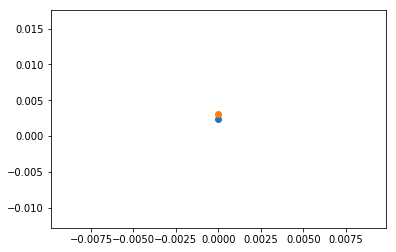

In [32]:
t = "Topic 84 #NeuralNetworks/HumanCognition"
f = (females_topics_proportions[t]) / fem_norm
m = (males_topics_proportions[t]) / male_norm
plt.scatter([0],[f])
plt.scatter([0],[m])

In [ ]:
females_topics = []
females_topics_proportions = defaultdict(int) # P(topic|gender)'
males_topics_proportions = defaultdict(int)
fem_norm = 0 # normalizer
male_norm = 0
males_topics = []
for i, file in enumerate(acl.modeling_files):
    try:
        topics = doc_topics[i]
        gender = df.loc[acl.get_id(file)]["genders"][0] #first author
        year = 
        if gender == Gender.female:
            for topic, p in topics:
                females_topics_proportions[topic_corresp[topic]] += p
            fem_norm +=1
        elif gender == Gender.male:
            for topic, p in topics:
                males_topics_proportions[topic_corresp[topic]] += p
            male_norm +=1
    except KeyError:
        pass

In [66]:
x = list(range(1965,2017))
prZ_y_fem = defaultdict(lambda: [0] * len(x))
prZ_y_male = defaultdict(lambda: [0] * len(x))
normD_y_fem = [0] * len(x)
normD_y_male = [0] * len(x)
for i, file in enumerate(acl.modeling_files):
    fid = acl.get_id(file)
    data = df.loc[fid]
    year = data["year"]
    topics = doc_topics[i]
    gender = data["genders"][0] #first author
    if gender == Gender.female:
        for topic, p in topics:
            prZ_y_fem[topic_corresp[topic]][int(year) - 1965] += p
        normD_y_fem[int(year) - 1965] += 1
        
    elif gender == Gender.male:
        normD_y_male[int(year) - 1965] += 1
        for topic, p in topics:
            prZ_y_male[topic_corresp[topic]][int(year) - 1965] += p
            
for topic_name, yg in prZ_y_fem.items():
    for y in x:
        if normD_y_fem[int(y) - 1965] != 0:
            yg[int(y) - 1965]  /= normD_y_fem[int(y) - 1965]

for topic_name, yg in prZ_y_male.items():
    for y in x:
        if normD_y_male[int(y) - 1965] != 0:
            yg[int(y) - 1965]  /= normD_y_male[int(y) - 1965]
    

In [68]:
man_topics = list(reversed(sorted(p_male.items(), key=lambda x: x[1])))

In [141]:
def plot_topic(tpc, name=None):
    if name == None:
        name = tpc.split(" ")[-1].replace("/","-")
    fig, ax = plt.subplots(1, 1)
    lst = prZ_y_male[tpc]
    ax.plot(x[:-1], lst[:-1], color=tableau20[0], label="Male")
    lst = prZ_y_fem[tpc]
    ax.plot(x[:-1], lst[:-1], color=tableau20[2], label="Female")
    b=np.arange(1965, 2016, 5)
    ax.set_ylabel("Odds ratio")
    ax.set_xticks(b)
    ax.set_title(name)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    plt.legend()
    plt.savefig(join(fd.plots, name +".pdf"))
    plt.show()
    

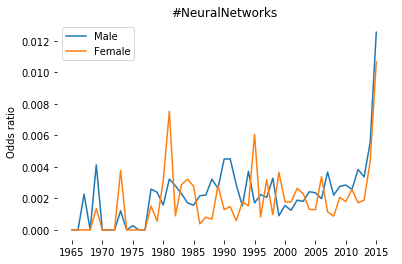

In [142]:
tpc = "Topic 84 #NeuralNetworks/HumanCognition"
plot_topic(tpc, name = "#NeuralNetworks")

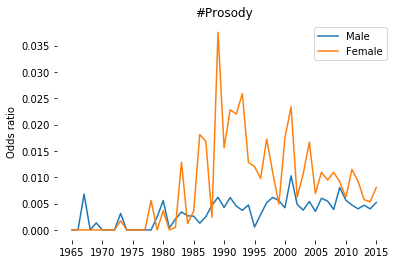

In [143]:
tpc = "Topic 62 #Prosody"
plot_topic(tpc, "#Prosody")

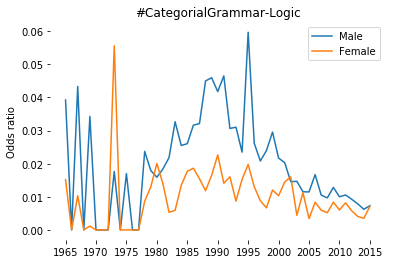

In [144]:
tpc = "Topic 72 #CategorialGrammar/Logic"
plot_topic(tpc)

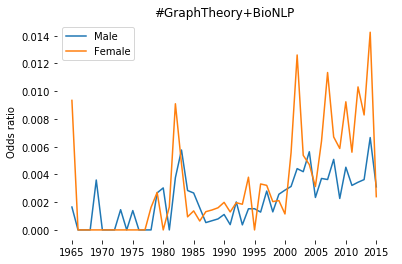

In [145]:
plot_topic("Topic 5 #GraphTheory+BioNLP")

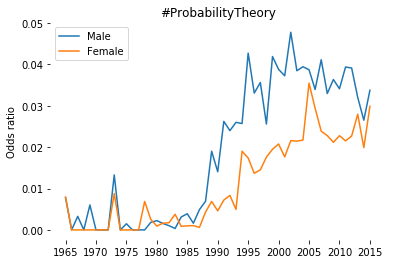

In [146]:
plot_topic("Topic 97 #ProbabilityTheory")

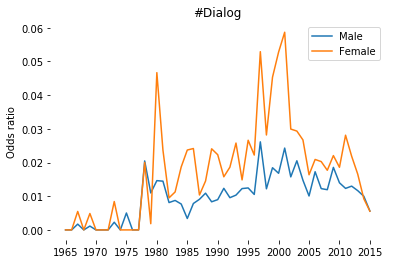

In [147]:
plot_topic("Topic 16 #Dialog")